In [17]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle

import evaluate
from model import LSTM, Transformer
from trainer import BenchmarkTrainer
from dataloader import GraphEnv, DataLoader, preprocess_zero_shot_dataset

In [18]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_random_seed(70)

In [53]:
# with open("data/data_n_nodes_9_env_grid_traj_len_12_n_traj_1536_args_{'rows': 3, 'cols': 3}_seed_65.pickle", "rb") as f:
#     p = pickle.load(f)

with open("data/data_n_nodes_9_env_tree_traj_len_12_n_traj_1536_args_{'levels': 3}_seed_65.pickle", "rb") as f:
    p = pickle.load(f)

env = p["env"]
train_dataloader = p["train_dataloader"]
test_dataloader = p["test_dataloader"]

In [60]:
hidden_dim = 512
epochs = 100
include_init_state_info = True
d_model, n_heads = 512, 8

model = LSTM(env.n_items, env.n_actions, env.size, hidden_dim, include_init_state_info=include_init_state_info)
#model = Transformer(env.n_items, env.n_actions, env.size, d_model, n_heads, hidden_dim, include_init_state_info)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

trainer = BenchmarkTrainer(
    model,
    train_dataloader,
    torch.optim.Adam(model.parameters()),
    torch.nn.CrossEntropyLoss(),
    test_loader=test_dataloader,
    include_init_state_info=include_init_state_info,
    reset_every=20,
    log = False
)

losses, model = trainer.train(epochs)

1091079


Epochs: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Text(0.5, 0, 'Epochs')

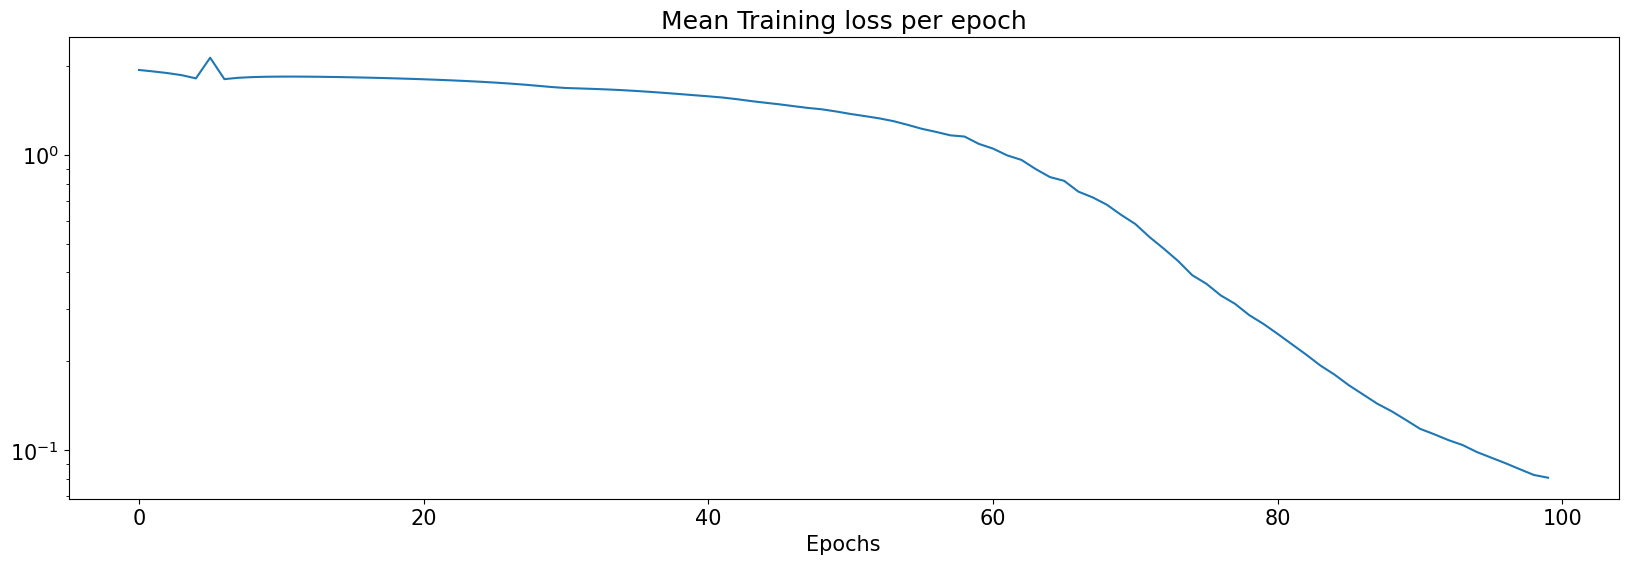

In [61]:
plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(losses, axis=1))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

In [62]:
train_acc, train_conf = evaluate.benchmark_accuracy(model, trainer.train_dataset)
test_acc, test_conf = evaluate.benchmark_accuracy(model, trainer.test_dataset)
print("Train acc/conf: ", train_acc, np.mean(train_conf))
print("Test acc/conf: ", test_acc, np.mean(test_conf))

Train acc/conf:  0.9924242496490479 0.9348056910164428
Test acc/conf:  1.0 0.9302872369686762


In [63]:
dataset = env.gen_zero_shot_dataset(trajectory_length=20, num_environments=20)
dataset = preprocess_zero_shot_dataset(model, dataset, include_init_state_info=include_init_state_info)

In [64]:
acc = evaluate.zero_shot_accuracy_benchmark(model, dataset, test_acc=True)
print("Test", acc)

Test 0.11578947368421053


In [65]:
acc = evaluate.zero_shot_accuracy_benchmark(model, dataset, test_acc=False)
print("Train", acc)

Train 0.1763157894736842
